In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("Dataset"))

## Adding in some more useful packages here
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

['liar_plus_test.csv', 'liar_plus_train.csv', '.ipynb_checkpoints', 'liar_plus_valid.csv']


In [2]:
!pip install wordcloud

In [25]:
embeddings_index = {}
f = open('glove6b50dtxt/glove.6B.50d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [26]:
df=pd.read_csv("Dataset/liar_plus_train.csv")

In [27]:
df.head()

,ID,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,extracted_justification
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,"But Vos specifically used the word ""fired,"" wh..."


In [28]:
df.dropna(subset = ["statement","context","extracted_justification"], inplace=True)

In [29]:
X_data=df["statement"]+df["extracted_justification"]

In [30]:
x=X_data

In [31]:
import re

## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in x: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords

print(texts[0:5])

[['decline', 'coal', 'start', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'w', 'bushs', 'administration', 'surovell', 'said', 'decline', 'coal', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'w', 'bushs', 'administration', 'doubt', 'natural', 'gas', 'gaining', 'ground', 'coal', 'generating', 'electricity', 'trend', 'started', '1990s', 'clearly', 'gained', 'speed', 'bush', 'administration', 'production', 'natural', 'gas', 'competitor', 'coal', 'picked', 'analysts', 'give', 'little', 'credit', 'blame', 'bush', 'trend', 'note', 'factors', 'technological', 'innovation', 'entrepreneurship', 'policies', 'previous', 'administrations', 'laying', 'groundwork', 'natural', 'gas', 'boom'], ['hillary', 'clinton', 'agrees', 'john', 'mccain', 'voting', 'give', 'george', 'bush', 'benefit', 'doubt', 'iran', 'obama', 'said', 'would', 'voted', 'amendment', 'present', 'though', 'clinton', 'may', 'agreed', 'mccain', 'issue', 'technically

In [32]:
# Code adapted from (https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)
# Vectorize the text samples

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NUM_WORDS = 2500
MAX_SEQUENCE_LENGTH = 80
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)



Found 24899 unique tokens.


In [33]:
from sklearn.preprocessing import LabelEncoder

In [34]:
le=LabelEncoder()

In [35]:
y=le.fit_transform(df["label"])

In [36]:
y

array([2, 3, 1, ..., 2, 1, 4])

In [37]:
labels = to_categorical(np.asarray(y))
print(data.shape)
print(labels.shape)

(10054, 80)
(10054, 6)


In [38]:
## More code adapted from the keras reference (https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)
# prepare embedding matrix 
from keras.layers import Embedding
from keras.initializers import Constant

## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

(2501, 50)


Text(0.5, 1.0, 'example vectors')

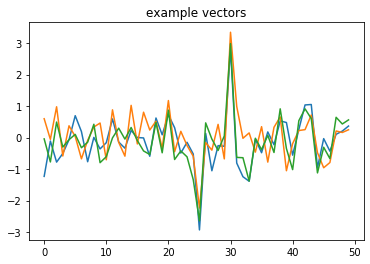

In [39]:
## Peeking at the embedding matrix values
print(embedding_matrix.shape)
plt.plot(embedding_matrix[16])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[18])
plt.title('example vectors')

In [51]:
## Code from: https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa
## To create and visualize a model

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

model = Sequential()
model.add(Embedding(num_words, 50, input_length=80, weights= [embedding_matrix], trainable=False))

model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(6, activation='relu'))





In [52]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
## Fit train data
print(labels.shape)
model.fit(data, np.array(labels), validation_split=0.1, epochs = 1)

(10054, 6)
Train on 9048 samples, validate on 1006 samples
Epoch 1/1
9048/9048 [==============================] - 8s 888us/step - loss: 1.7567 - accuracy: 0.2051 - val_loss: 1.7623 - val_accuracy: 0.2038


In [23]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [75]:
def embedding_output(data):
    emb_dim=50
    max_len=80
    emb=np.zeros((data.shape[0],max_len,emb_dim))
    print(emb.shape)
    for i in range(data.shape[0]):
        
        for j in range(80):
         try:
            emb[i][j]=embeddings_index[data[i][j].lower()]
         except:
            emb[i][j]=np.zeros((50,))
    return emb


In [76]:
min(MAX_NUM_WORDS, len(word_index)) + 1

2501

In [77]:
e=embedding_output(texts)

(10054, 80, 50)


In [49]:
texts=np.array(texts)

In [51]:
texts.shape

(10054,)

In [56]:
texts[0].split

AttributeError: 'list' object has no attribute 'split'

In [79]:
e.shape

(10054, 80, 50)